### **Study area visuallization.**
### 1) Spatial loaction of tibetan region 
### 2) Spatial distribution of dset (training and validation data, respectively.).

In [2]:
import warnings
warnings.filterwarnings("ignore")
from notebooks import config
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from utils.transform_xy import coor2coor
from shapely.geometry import Polygon
import numpy as np
import pandas as pd
import geopandas as gpd
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from matplotlib.colors import LinearSegmentedColormap
from utils.raster_vec import vec2mask
import glob
import os
import gc


### Extract scenes footprint and center coordinates from .tif images in dataset.

In [3]:
paths_truth = glob.glob('data/dset/s1_truth_clean/*truth.tif')
paths_truth = sorted(paths_truth)
scene_ids = []; fprint_wgs84 = []; 
centers_lat = []; centers_lon = []
for path in paths_truth:
    ## 1. extract scene ids
    scene_id = os.path.basename(path)[0:7]
    scene_ids.append(scene_id)
    ## 2. extract footprints
    img, img_info = readTiff(path)
    lon_1, lon_2, lat_1, lat_2 = img_info['geoextent']
    lons = [lon_1, lon_2, lon_2, lon_1, lon_1]
    lats = [lat_1, lat_1, lat_2, lat_2, lat_1]
    lon_wgs84, lat_wgs84 = coor2coor(srs_from=img_info['geosrs'], srs_to=4326, x=lons, y=lats)
    fprint = Polygon(zip(lon_wgs84, lat_wgs84))
    fprint_wgs84.append(fprint)
    ## 3. extract centers of footprints
    center_lon = fprint.centroid.coords[0][0]
    center_lat = fprint.centroid.coords[0][1]
    centers_lat.append(center_lat); centers_lon.append(center_lon);

print('number of scene_ids:',len(scene_ids)); print('sample:', scene_ids[0])
# print('number of footprints:',len(fprint_wgs84)); print('sample:', fprint_wgs84[0])
# print('number of centers_lat:',len(centers_lat)); print('sample:', centers_lat[0])
# print('number of centers_lon:',len(centers_lon)); print('sample:', centers_lon[0])


number of scene_ids: 39
sample: scene01


### Extract scene footprints from the dset.

In [4]:
### write the data information to geopandas
scenes_tra = ['scene'+id for id in config.tra_ids]

traset = ['true' if scene_ids[id] in scenes_tra else 'false' for id in range(len(scene_ids))]
df = pd.DataFrame({'scene_id': scene_ids, \
                    'center_lat': centers_lat,
                    'center_lon': centers_lon,
                    'train': traset
                    })           ## scene id

fp_geodf = gpd.GeoDataFrame(df, geometry=fprint_wgs84, crs=4326)
print(fp_geodf.head())
fp_geodf.to_file('data/dset/loc_vec/scene_footprint.shp')   ## save the footprint file



  scene_id  center_lat  center_lon  train  \
0  scene01   33.993820   82.454392  false   
1  scene02   34.775096   98.139610  false   
2  scene03   28.995082   90.809708  false   
3  scene04   35.630093   86.879776  false   
4  scene05   33.964141   89.960146  false   

                                            geometry  
0  POLYGON ((82.25568 33.84709, 82.64803 33.84246...  
1  POLYGON ((97.93004 34.61704, 98.35243 34.62001...  
2  POLYGON ((90.61015 28.83351, 91.01593 28.84009...  
3  POLYGON ((86.67000 35.47958, 87.09000 35.48000...  
4  POLYGON ((89.78144 33.82872, 90.12918 33.82038...  


### Load the prepared data

In [5]:
path_dset_fprint = 'data/dset/loc_vec/scene_footprint.shp'
path_tibet_boundry = 'data/tibet/tibet-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'
path_tibet_dem = 'data/tibet/dem/tibet_SRTMGL3_900m.tif'
path_water_jrc = 'data/tibet/jrc_water/tibet_water_jrc_1000m.tif'



In [6]:
## Convert vector to image. the image is regard as mask. 
mask_tibet = vec2mask(path_vec=path_tibet_boundry, path_raster=path_tibet_dem, path_save=None)
mask_tibet.shape


(2280, 4560)

In [7]:
water_jrc, water_jrc_info= readTiff(path_water_jrc)
tibet_dem, tibet_dem_info = readTiff(path_tibet_dem)
tibet_dem_masked = np.ma.masked_where(mask_tibet == 0, tibet_dem).astype(np.float16).filled(np.nan)
water_jrc_masked = np.ma.masked_where(water_jrc == 0, water_jrc).astype(np.float16).filled(np.nan)
print(tibet_dem_info['geoextent'])
print(water_jrc_info['geoextent'])
print('dem shape: ', tibet_dem.shape)
print('water map shape: ', water_jrc_masked.shape)


(69.99958333327652, 107.99958333326788, 23.000416666675076, 42.00041666667076)
(73.49827008456259, 104.42277374037712, 25.99499853420866, 39.988954030222565)
dem shape:  (2280, 4560)
water map shape:  (1557, 3442)


### Extract scenes center coordinates of dataset

In [8]:
geodf_fp = gpd.read_file(path_dset_fprint)
geodf_fp.head()


,scene_id,center_lat,center_lon,train,geometry
0,scene01,33.993820,82.454392,false,"POLYGON ((82.25568 33.84709, 82.26007 34.14503..."
1,scene02,34.775096,98.139610,false,"POLYGON ((97.93004 34.61704, 97.92599 34.92996..."
2,scene03,28.995082,90.809708,false,"POLYGON ((90.61015 28.83351, 90.60286 29.14987..."
3,scene04,35.630093,86.879776,false,"POLYGON ((86.67000 35.47958, 86.66876 35.78000..."
4,scene05,33.964141,89.960146,false,"POLYGON ((89.78144 33.82872, 89.79055 34.10779..."


### Visuallization for study area and dset

In [9]:
# cmap_dem = LinearSegmentedColormap.from_list('linear color', ["black", "white"])
cmap_dem = LinearSegmentedColormap.from_list('linear color', ["DimGray", "white"])
cmap_water = LinearSegmentedColormap.from_list('linear color', ["lightBlue", 'Blue'])


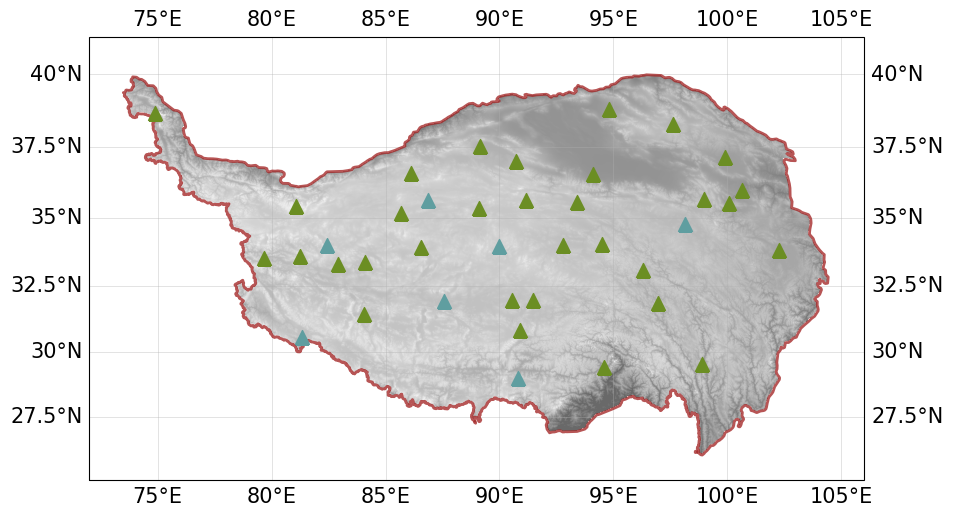

In [12]:
plt.rcParams.update({'font.size': 15})
alpha_water = np.clip((water_jrc/100.0), 0.4, 0.8) [::-1, :]  ## !!!flip from y-axis
centers_lat_tra = geodf_fp['center_lat'][geodf_fp['train']=='true'].values
centers_lon_tra = geodf_fp['center_lon'][geodf_fp['train']=='true'].values
centers_lat_val = geodf_fp['center_lat'][geodf_fp['train']=='false'].values
centers_lon_val = geodf_fp['center_lon'][geodf_fp['train']=='false'].values

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([72, 106, 25.0, 40.0])
# 1. tibet boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_boundry).geometries(), \
                                crs=ccrs.PlateCarree(), edgecolor='Brown', alpha=0.8, \
                                linestyle='-', linewidth=2, facecolor='none')
ax.add_feature(shp_fea, zorder=2)

## 2. dem image
ax_dem = ax.imshow(tibet_dem_masked, extent=tibet_dem_info['geoextent'], 
                                vmin=1000, vmax=7000, cmap=cmap_dem, \
                                transform=ccrs.PlateCarree(), zorder=1)  # cmap:PRGn
ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)

# # ## 3. water map
# ax_water = ax.imshow(water_jrc_masked, extent=water_jrc_info['geoextent'], \
#                                 vmin=1, vmax=100, alpha=alpha_water, interpolation='none', \
#                                 cmap=cmap_water, transform=ccrs.PlateCarree(), zorder=1)

## 4. scene samples
ax.scatter(x=centers_lon_tra, y=centers_lat_tra, color='OliveDrab', \
                                marker='^', s=100, alpha=1, transform=ccrs.PlateCarree(), zorder=2)
ax.scatter(x=centers_lon_val, y=centers_lat_val, color='CadetBlue', \
                                marker='^', s=100, alpha=1, transform=ccrs.PlateCarree(), zorder=2)


# plt.colorbar(ax_dem, fraction=0.025, pad=0.15, label='Elevation (m)')  #
# plt.colorbar(ax_water, fraction=0.025, pad=0.15, label='Water occurrence')   #
# plt.savefig(config.root_proj + '/figure/study_area.png', bbox_inches='tight')



### Sub-figure for study area

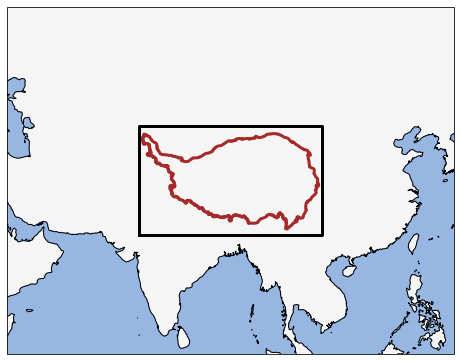

In [102]:
region_x = [73, 105, 105, 73, 73]
region_y = [25, 25, 41, 41, 25]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))
# ax.stock_img()
ax.add_feature(cfeature.LAND, facecolor='WhiteSmoke')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE, edgecolor='Black')
ax.set_extent([50, 128, 5, 48.0])
# ax.gridlines(draw_labels=True,linewidth=0)
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_boundry).geometries(), \
                                crs=ccrs.PlateCarree(), linewidth=3, edgecolor='Brown', facecolor='none')
ax.add_feature(shp_fea, zorder=1)
# ax.gridlines(draw_labels=False)
plt.plot(region_x, region_y, transform=ccrs.PlateCarree(), linewidth=3, color='black')
